In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
import pmdarima as pm
import statsmodels.api as sm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv("train.csv", index_col = 'Date', parse_dates=['Date'])
test = pd.read_csv("test.csv", index_col = 'Date')

# train_big = pd.read_csv("train.csv", index_col = 'Date', parse_dates=['Date'])
# train = train_big.iloc[0:(len(train_big)-30)]
# test = train_big.iloc[len(train):(len(train_big)-1)]

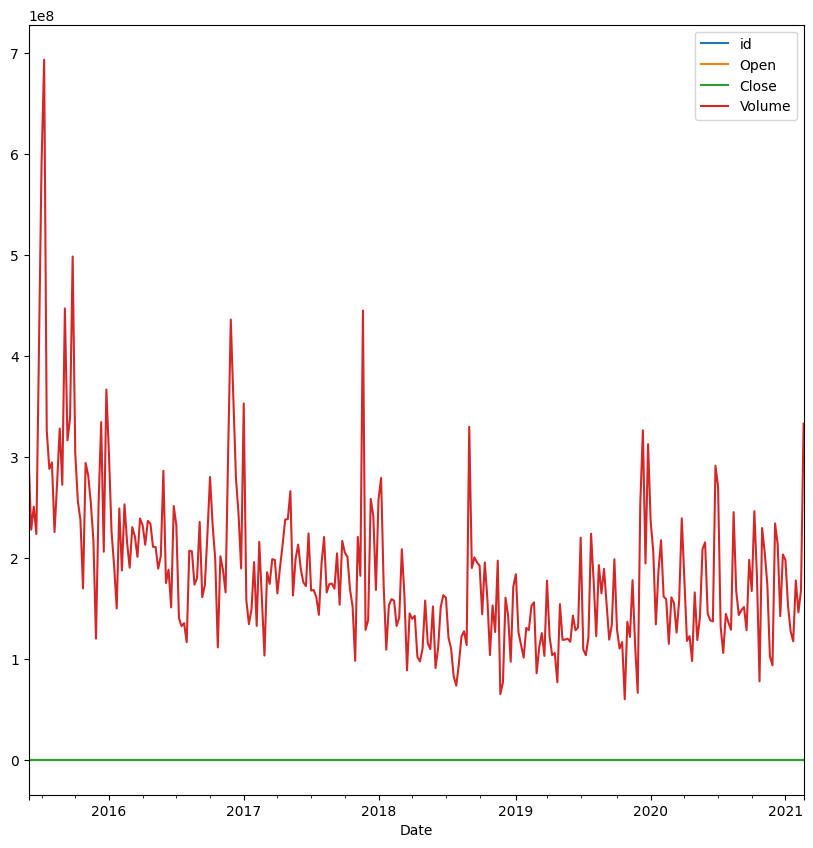

In [3]:
train.plot(figsize=(10,10))
plt.show()

In [4]:
# SARIMAX MODEL 1
arima_order = (4,1,2)
endog = train.Close
exog = sm.add_constant(train[['Open','Volume']])
mod = sm.tsa.statespace.SARIMAX(endog=endog, train_exog=exog, order=arima_order)
model_fit = mod.fit()

test_exog = sm.add_constant(test[['Open','Volume']])
sarimax_forecast = model_fit.forecast(exog=test_exog,steps=100)
print(sarimax_forecast.head())



C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['train_exog']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as st

2021-03-01    78.903427
2021-03-08    77.941496
2021-03-15    77.766755
2021-03-22    78.592379
2021-03-29    79.248305
Freq: W-MON, Name: predicted_mean, dtype: float64


C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
# SARIMAX model 2
# new order, but same exogenous variables
endog = train.Close
arima_order = (1,0,1)
seasonal_o = (4,0,4,5)
exog = sm.add_constant(train[['Open','Volume']])
mod = sm.tsa.statespace.SARIMAX(endog=endog, train_exog=exog, order=arima_order,seasonal_order=seasonal_o)
model_fit = mod.fit()

test_exog = sm.add_constant(test[['Open','Volume']])
sarimax_forecast3 = model_fit.forecast(exog=test_exog,steps=100)
sarimax3_train = model_fit.forecast(exog=exog,steps=100)
print(sarimax_forecast3.head())


C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['train_exog']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting pa

2021-03-01    79.535901
2021-03-08    79.579769
2021-03-15    80.264688
2021-03-22    79.852723
2021-03-29    80.129403
Freq: W-MON, Name: predicted_mean, dtype: float64


C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
def findMovingAvg(datas,column, win):
    moving_avg = datas[column].rolling(window=win).mean()
    return moving_avg

In [7]:
def getMAUsingTrainTest(train,test,column,win):
    merged = pd.concat([train,test])
    merged_moving_avg = findMovingAvg(merged,column,win)
    merged[f'{column}MovingAvg_{win}'] = merged_moving_avg
    together = pd.merge(test,merged[f'{column}MovingAvg_{win}'],on='Date',how='inner')
    return together[f'{column}MovingAvg_{win}']

In [8]:
def getLagged(datas,column,lag):
    datas[f'{column}Lag_{lag}'] = datas[column].shift(1)
    datas = datas.dropna(subset=f'{column}Lag_{lag}')
    return datas[f'{column}Lag_{lag}']

In [9]:
def getTrainTestlag(train,test,column,lag):
    merged = pd.concat([train,test])
    merged_lag = getLagged(merged,column,lag)
    merged[f'{column}Lag_{lag}'] = merged_lag
    together = pd.merge(test,merged[f'{column}Lag_{lag}'],on='Date',how='inner')
    return together[f'{column}Lag_{lag}']

In [10]:
train_dataset = train
# train_dataset['OpenMovingAvg_12'] = findMovingAvg(train,'Open',12)
train_dataset['OpenMovingAvg_4'] = findMovingAvg(train,'Open',4)
# train_dataset['VolumeMovingAvg_12'] = findMovingAvg(train,'Volume',12)
train_dataset['VolumeMovingAvg_4'] = findMovingAvg(train,'Volume',4)
train_dataset['OpenLag_1'] = getLagged(train,'Open',1)
train_dataset['VolumeLag_1'] = getLagged(train,'Volume',1)
train_dataset

,id,Open,Close,Volume,Strategy,OpenMovingAvg_4,VolumeMovingAvg_4,OpenLag_1,VolumeLag_1
Date,,,,,,,,,
2015-06-01,0,66.208486,75.609978,298506300,Hold,NaN,NaN,NaN,NaN
2015-06-08,1,64.116235,74.443331,227974800,Hold,NaN,NaN,66.208486,298506300.0
2015-06-15,2,47.701942,71.140831,250670900,Buy,NaN,NaN,64.116235,227974800.0
2015-06-22,3,54.754816,72.881344,223614300,Hold,58.195370,250191575.0,47.701942,250670900.0
2015-06-29,4,48.031899,66.284718,406814900,Buy,53.651223,277268725.0,54.754816,223614300.0
...,...,...,...,...,...,...,...,...,...
2021-01-25,295,81.284821,83.373498,117281600,Sell,80.569815,148649875.0,80.663736,127248000.0
2021-02-01,296,71.970249,85.294903,177655800,Sell,78.439755,143587275.0,81.284821,117281600.0
2021-02-08,297,71.784627,83.266453,146003500,Hold,76.425859,142047225.0,71.970249,177655800.0


In [15]:
test_dataset = test
test_dataset['OpenMovingAvg_4'] = getMAUsingTrainTest(train,test,'Open',4)
test_dataset['VolumeMovingAvg_4'] = getMAUsingTrainTest(train,test,'Volume',4)
test_dataset['OpenLag_1'] = getTrainTestlag(train,test,'Open',4)
test_dataset['VolumeLag_1'] = getTrainTestlag(train,test,'Volume',4)
test_dataset

,id,Open,Volume,OpenMovingAvg_4,VolumeMovingAvg_4,OpenLag_1,VolumeLag_1
Date,,,,,,,
2021-03-01,0,72.708331,205897600,70.870978,213160700.0,69.618620,332979200.0
2021-03-08,1,73.310886,214095600,71.252543,230183725.0,72.708331,205897600.0
2021-03-15,2,70.610119,151601700,71.561989,226143525.0,73.310886,214095600.0
2021-03-22,3,70.256017,193982500,71.721338,191394350.0,70.610119,151601700.0
2021-03-29,4,68.258324,220238400,70.608836,194979550.0,70.256017,193982500.0
...,...,...,...,...,...,...,...
2022-12-26,95,57.048622,224994700,57.519659,230052950.0,55.184092,291865900.0
2023-01-02,96,60.569661,176020500,57.805033,227177425.0,57.048622,224994700.0
2023-01-09,97,61.446777,181478600,58.562288,218589925.0,60.569661,176020500.0


In [12]:
# adding moving average feature here
# in train, the columns before the window will be removed
ma_window = 12
train_endog = train.Close
train_endog = train_endog.iloc[ma_window-1:]
train_exog = sm.add_constant(train[['Open','Volume']])
train_exog['MovingAvg_12'] = findMovingAvg(train.Open,12)
train_exog['MovingAvg_4'] = findMovingAvg(train.Open,4)
train_exog = train_exog.dropna(subset=['MovingAvg_12'])

# for test, moving avg from train data is also considered
# e =  getMAUsingTrainTest(train,test,ma_window)
test_exog = sm.add_constant(all_ma[['Open','Volume','MovingAvg_12','MovingAvg_4']])

TypeError: findMovingAvg() missing 1 required positional argument: 'win'

In [ ]:
mod3 = sm.tsa.statespace.SARIMAX(endog=train_endog, exog=train_exog, order=arima_order,seasonal_order=seasonal_o)
model_fit3 = mod3.fit()

sarimax_forecast3_ma = model_fit3.forecast(exog=test_exog,steps=100)
sarimax_forecast3_ma.tolist()

C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Anagha Siddheshwar\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[76.09162066028897,
 75.1538620748199,
 76.85952883965858,
 76.77707518294808,
 76.61897300271437,
 74.9317057386894,
 73.70139890937904,
 73.97782056664703,
 75.3129582861482,
 76.13918285457616,
 74.00006372532502,
 74.7362617278446,
 73.31365561333357,
 75.77193307911064,
 76.14411535795077,
 77.34703819284367,
 77.43244153290382,
 75.80385305773034,
 73.2309363941667,
 72.96688188144431,
 73.34751474327605,
 75.04362501152265,
 76.28799383575324,
 77.97252760327,
 80.08984264730083,
 80.67716403644276,
 81.07897411958434,
 82.05701498888496,
 81.21550191809499,
 83.04638459426467,
 81.79330629732233,
 82.76866437434714,
 81.1648741066456,
 83.52892442896709,
 83.99212071777197,
 84.86892333988796,
 86.38012023893165,
 84.47297289294237,
 86.3284088955773,
 89.8986645130202,
 89.05004513713973,
 85.29809490586767,
 81.07126899058602,
 78.32272725691446,
 77.03760046322024,
 77.12271211496441,
 75.53760383124185,
 74.99294578454133,
 75.88092922275516,
 76.97916023916063,
 75.8125709

In [ ]:
def getLag(datas,column,lag):
    datas[f'{column}Lag_{lag}'] = datas[column].shift(1)
    datas = datas.dropna(subset=f'{column}Lag_{lag}')
    return datas[f'{column}Lag_{lag}']

In [ ]:
def getTrainTestlag(train,test,column,lag):
    merged = pd.concat([train,test])
    merged_lag = getLag(merged,column,lag)
    merged[f'{column}Lag_{lag}'] = merged_lag
    together = pd.merge(test,merged[f'{column}Lag_{lag}'],on='Date',how='inner')
    return together[f'{column}Lag_{lag}']

In [ ]:
# train data for Strategy
# train_data = train_endog.iloc[12-1:]
# train_data['Strategy'] = train.Strategy
train_data = sm.add_constant(train[['Open','Volume']])
train_exog['MovingAvg_12'] = findMovingAvg(train.Open,12)
train_exog['MovingAvg_4'] = findMovingAvg(train.Open,4)
train_exog['OpenLag_1'] = getLag(train,'Open',1)
train_exog['VolumeLag_1'] = getLag(train,'Volume',1)
train_exog = train_exog.dropna(subset=['MovingAvg_12'])

In [ ]:
def randomForestStrategyWithMALag(train,test,close_forecast):
    clf = RandomForestClassifier(n_estimators=100)
    X_train = train[['Open','Volume','MovingAvg_12','MovingAvg_4','OpenLag_1','VolumeLag_1','Close']]
    y_train = train['Strategy']
    clf.fit(X_train, y_train)

    test['Close'] = close_forecast.tolist()
    X_test = test[['Open','Volume','MovingAvg_12','MovingAvg_4','OpenLag_1','VolumeLag_1''Close']]
    strategy_pred = clf.predict(X_test)
    return strategy_pred